In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import random

Сгенерируем произвольную выборку:

In [5]:
random.seed(7)
X = np.random.randint(0,2,20).reshape(5,4) #randint(0,2,20).reshape(5,4) or randint(0,2,(5,4)) --> random((5,4),20) 
Y = np.random.randint(0,2,5).reshape(-1,1)

In [6]:
params =  np.random.random((1,5)).reshape(-1,1)  # коэф. 4  и 1 порог

Создаем функцию нахождения логита(сигмоид от параметра х). Логит находится один для одного вектора х_i, можно сказать эквивалента вероятности, так как результат всегда находится от 0 до 1.

In [2]:
def logit(x, alpha):
    return (1/(1+np.exp( -x@alpha[:-1]   - alpha[-1] ) ) )

In [3]:
def logit_result(x, alpha):
    return (logit(x, alpha).T > .5).astype(int)

In [7]:
logit(X,params).T, logit_result(X,params) , Y.T

(array([[0.81415327, 0.89448147, 0.57748716, 0.72563697, 0.87930117]]),
 array([[1, 1, 1, 1, 1]]),
 array([[1, 1, 0, 1, 1]]))

Функция потерь, которая принимает на вход результат логита и выдает на сколько результат отклоняется от настоящего значения.  

Результат один для всех векторов x_i

In [8]:
def loss_function(x, alpha, y_):
    a = logit(x,alpha)
    l= -1. *( np.sum(  1.  *y_*np.log( a[y_!=0]+1e-6 )   ) + np.sum(  (1 - y_ )* np.log( 1. - a[y_==0] )  )   ) / len(y_)
    return l


Нужно оптимизировать параметры. Используем метод градиентного спуска: 

Будем искать производную функции потерь . Через **sympy**

In [151]:
import sympy 
from sympy import *
x,y,a, w0 = symbols( 'x y a w0')

In [152]:
expression = 1 / (1+ exp(-a*x - w0  ))
expression

1/(exp(-a*x - w0) + 1)

In [153]:
expression_loss_f = -y*log(expression) - (1-y)*log(1-expression)
expression_loss_f

-y*log(1/(exp(-a*x - w0) + 1)) - (1 - y)*log(1 - 1/(exp(-a*x - w0) + 1))

In [154]:
expression_loss_f_dif_a = simplify(  diff(expression_loss_f,a)  )
expression_loss_f_dif_w0 = simplify(  diff(expression_loss_f,w0) )

Теперь посчитаем для каждого x_i_j 

#### Cчитаем градиент:

Считаем градиент для альфа (коэффициентов при х_i)

In [58]:
grad_a = lambdify([y,x,a,w0] ,expression_loss_f_dif_a, 'numpy')

In [60]:
# упакуем в функцию grad_a_calculate
def grad_a_calculate(features, category, alpha):
    grad_a_sum_array = [0 , 0 , 0 , 0]
    
    for  i in range( features.shape[0] ):
        l = grad_a(category[i],features[i],alpha[:-1].T,alpha[-1]) 
        # print( l )
        grad_a_sum_array += l                               # Складываем, а потом разделим на число векторов Х, чтобы найти среднюю.
    grad_a_sum_array = grad_a_sum_array / features.shape[0] # разделили на число векторов Х, чтобы найти среднюю.
    return grad_a_sum_array                                 # Средняя градиента альфа(тета) по всем Х

In [61]:
grad_a_calculate(X,Y,params)

array([[-0.000, -0.000, -0.000, 0.001]])

Считаем градиент bias - как бы отступа для h(x_i) 

In [62]:
grad_w0 = lambdify([y,x,a,w0] ,expression_loss_f_dif_w0, 'numpy')

In [64]:
# упакуем в функцию grad_w0_calculate
def grad_w0_calculate(features, category, alpha):
    grad_w0_sum_array = [0]

    for  i in range( features.shape[0] ):
        l = grad_w0(category[i],0,0,alpha[-1]) # x и alpha НЕ зависят от bias, то есть это получается как бы нулевой Х0=0 и alpha0=0 
        #print( l )
        grad_w0_sum_array += l                 # Складываем, а потом разделим на число векторов Х, чтобы найти среднюю.
    grad_w0_sum_array = grad_w0_sum_array / features.shape[0] # разделили на число векторов Х, чтобы найти среднюю.
    return grad_w0_sum_array                   # Средняя градиента биаса по всем Х

In [65]:
grad_w0_calculate(X,Y,params)

array([0.000])

#### Запускаем градиентный спуск:

In [11]:
# Уменьшим дробную часть в выводе нампи
np.set_printoptions(suppress=True, formatter={ 'float_kind': '{:.3f}'.format  })

In [141]:
params =  np.random.random((1,5)).T 
print('Initial coefficients are: \n',params.T)
learning_rate = 1
print('Loss funct \t|\t bias \t\t|\t alpha  ')
print('-'*85)

for i in range(100):      # 100 эпох
    params[-1] -= learning_rate * grad_w0_calculate(X,Y,params)
    params[:-1] -= learning_rate * grad_a_calculate(X,Y,params).T
    l = loss_function(X, params, Y)
    if i %10 ==0: print(f'{l :.3f}\t \t|\t {params[-1] } \t|\t {params[:-1].T }  ')
    if np.abs(l) < .1 : break

Initial coefficients are: 
 [[0.077 0.958 0.995 0.452 0.335]]
Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
2.799	 	|	 [0.152] 	|	 [[0.054 0.556 0.843 0.452]]  
1.404	 	|	 [-0.371] 	|	 [[0.199 -0.593 -0.191 0.452]]  
1.315	 	|	 [-0.403] 	|	 [[0.328 -0.680 -0.783 0.452]]  
1.282	 	|	 [-0.405] 	|	 [[0.378 -0.691 -1.186 0.452]]  
1.266	 	|	 [-0.405] 	|	 [[0.396 -0.693 -1.487 0.452]]  
1.257	 	|	 [-0.405] 	|	 [[0.402 -0.693 -1.725 0.452]]  
1.251	 	|	 [-0.405] 	|	 [[0.404 -0.693 -1.921 0.452]]  
1.246	 	|	 [-0.405] 	|	 [[0.405 -0.693 -2.087 0.452]]  
1.243	 	|	 [-0.405] 	|	 [[0.405 -0.693 -2.231 0.452]]  
1.240	 	|	 [-0.405] 	|	 [[0.405 -0.693 -2.357 0.452]]  


In [142]:
logit(X,params).T,   (logit(X,params).T > .5).astype(int)   ,   Y.T

(array([[0.400, 0.028, 0.250, 0.333, 0.333]]),
 array([[0, 0, 0, 0, 0]]),
 array([[1, 0, 0, 0, 1]]))

**ОБЛОМ**

Качество градиента от sympy не очень хорошее 

**Если кто то из экспертов скажет в чем причина: почему градиент посчитанный sympy, не совпадает с градиентом из формулы ниже. Я буду очень признателен!**


Буду использовать формулу градиента:

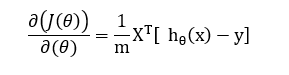

In [14]:
from IPython.display import Image
Image("der_loss_func.png")

Это формулы от sympy: 

In [155]:
# Градиент для тета
expression_loss_f_dif_a

x*(-y*exp(-a*x - w0) - y + 1)/(exp(-a*x - w0) + 1)

In [156]:
# Градиент для биаса
expression_loss_f_dif_w0

(-y*exp(-a*x - w0) - y + 1)/(exp(-a*x - w0) + 1)

In [108]:
Y = Y.reshape(-1,1)

In [20]:
def deriv_loss_function(x, alpha, y_):
    a = logit(x,alpha) - y_
    coef = a*x
    return np.mean(coef,axis=0).reshape(-1,1) , np.mean(a,axis=0)

In [133]:
deriv_loss_function(X,params,Y)

(array([[-0.007],
        [0.013],
        [0.003],
        [0.000]]),
 array([-0.007]))

In [139]:
params =  np.random.random((1,5)).T 
#params = np.array([0.253,0.333,0.661,0.877,0.473]).reshape(5,1)
learning_rate = .1
print('Loss funct \t|\t bias \t\t|\t alpha  ')
print('-'*85)
epoch = 30

for i in range(epoch):
    grad_alfa, grad_bias = deriv_loss_function(X,params,Y_)
    params[-1] -= learning_rate * grad_bias
    params[:-1] -= learning_rate * grad_alfa
    l = loss_function(X, params, Y_)
    if i %5 ==0: print(f'{l :.3f}\t \t|\t {params[-1] } \t|\t {params[:-1].T }  ')
    if np.abs(l) < .1 : break

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
32.914	 	|	 [0.141] 	|	 [[0.078 0.133 0.424 0.271]]  
21.655	 	|	 [0.085] 	|	 [[-0.158 -0.087 0.475 0.312]]  
17.619	 	|	 [0.066] 	|	 [[-0.194 -0.179 0.607 0.372]]  
14.784	 	|	 [0.052] 	|	 [[-0.222 -0.256 0.716 0.422]]  
12.711	 	|	 [0.039] 	|	 [[-0.245 -0.320 0.810 0.465]]  
11.140	 	|	 [0.028] 	|	 [[-0.265 -0.376 0.891 0.502]]  


In [140]:
logit_result(X,params) , Y.T 

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2

Выполним задачу для цветочков ириса:

In [252]:
from sklearn.datasets import load_iris

iris = load_iris()

# Зкгрузим вектора и разметку
X = iris.data
Y = iris.target

In [253]:
# сгенерим рандомные коэффициенты и биас
params =  np.random.random((1,5)).T  # коэф. 4  и 1 порог

In [254]:
import copy
Y = Y.reshape(-1,1)
Y_ = copy.copy(Y) 
np.place(Y_, Y_ != 0, 1)

Не радостный резултат если использовать дериватив (производную в **sympy**).  
Посмотрим на результат, если использовать выведенную производую :

In [226]:
params =  np.random.random((5,1)) 
learning_rate = .1
print('Loss funct \t|\t bias \t\t|\t alpha  ')
print('-'*85)

for i in range(300):
    grad_alfa, grad_bias = deriv_loss_function(X,params,Y_)
    params[-1] -= learning_rate * grad_bias
    params[:-1] -= learning_rate * grad_alfa
    l = loss_function(X, params, Y_)
    if i %50 ==0: print(f'{l :.3f}\t \t|\t {params[-1] } \t|\t {params[:-1].T }  ')
    if np.abs(l) < .1 : break

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
108.459	 	|	 [0.215] 	|	 [[0.754 0.545 0.296 0.878]]  
7.435	 	|	 [-0.053] 	|	 [[-0.248 -0.567 0.876 1.200]]  
4.131	 	|	 [-0.098] 	|	 [[-0.324 -0.813 1.242 1.360]]  
2.890	 	|	 [-0.125] 	|	 [[-0.369 -0.963 1.468 1.459]]  
2.237	 	|	 [-0.145] 	|	 [[-0.400 -1.073 1.632 1.531]]  
1.832	 	|	 [-0.160] 	|	 [[-0.425 -1.159 1.762 1.587]]  


In [227]:
logit_result(X,params) , Y.T 

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2

### Nesterov_accel_descend

In [228]:
def nesterov_accel_descend(x_,alpha, y_, l_i_1 , gamma):
    
    alpha = alpha - gamma * l_i_1
    
    grad_alpha, grad_bias = deriv_loss_function(x_,alpha,y_)
    grad = np.append(grad_alpha, grad_bias).reshape(-1,1)

    l_i = gamma * l_i_1 + (1. - gamma)* grad
    alpha -= l_i 
    
    return alpha, l_i

In [229]:
# Запускаем Нестеров
params =  np.random.random((5,1)) 

learning_rate = .05
epoch = 30

step_i= np.random.random((5,1))/100 #начальный отступ
gamma = 1-learning_rate             
print('Loss funct \t|\t bias \t\t|\t alpha  ')
print('-'*85)

for i in range(epoch):
    
    params, step_i = nesterov_accel_descend(X,params,Y_, step_i, gamma)
    
    l = loss_function(X, params, Y_)
    
    if i %5 ==0: print(f'{l :.3f}\t \t|\t {params[-1] } \t|\t {params[:-1].T }')
    if np.abs(l) < .1 : break
    

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
58.949	 	|	 [0.817] 	|	 [[0.311 0.211 0.235 0.099]]
22.196	 	|	 [0.652] 	|	 [[0.004 -0.335 0.916 0.404]]
3.258	 	|	 [0.379] 	|	 [[-0.654 -1.385 2.059 0.948]]
3.114	 	|	 [0.163] 	|	 [[-1.099 -2.273 3.194 1.471]]


In [230]:
logit_result(X,params) , Y_.T 

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1

Perfect. Pезультаты логита по Нестеров(Y_pred) совпали с Y.

### RMS_prop

In [231]:
def RMS_prop(x_,alpha,y_, gamma, square_grad_mean_i_1):

    grad_alpha, grad_bias = deriv_loss_function(x_,alpha,y_)
    
    grad = np.append(grad_alpha, grad_bias).reshape(-1,1)
    
    square_grad_mean_i = gamma * square_grad_mean_i_1 + (1 - gamma)*grad**2 
    alpha -= (1-gamma)* grad / (square_grad_mean_i + 1e-6)**.5
    
    
    return alpha, square_grad_mean_i

In [232]:
# Запускаем RMS_prop
params =  np.random.random((5,1)) 

learning_rate = .05
epoch = 30

step_i = np.random.random((5,1))/100 #начальный шаг
gamma = 1-learning_rate             
print('Loss funct \t|\t bias \t\t|\t alpha  ')
print('-'*85)

for i in range(epoch):
    
    params , step_i = RMS_prop(X,params,Y_,gamma, step_i)
    
    l = loss_function(X, params, Y_)
    if i %5 ==0: print(f'{l :.3f}\t \t|\t {params[-1] } \t|\t {params[:-1].T }')
    if np.abs(l) < .1 : break
    

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
41.936	 	|	 [0.262] 	|	 [[0.387 -0.040 -0.119 0.063]]
23.634	 	|	 [0.015] 	|	 [[0.164 -0.381 0.192 0.429]]
14.517	 	|	 [-0.101] 	|	 [[0.082 -0.549 0.455 0.682]]
10.304	 	|	 [-0.184] 	|	 [[0.026 -0.670 0.641 0.859]]
7.824	 	|	 [-0.249] 	|	 [[-0.017 -0.765 0.791 1.000]]
6.195	 	|	 [-0.303] 	|	 [[-0.051 -0.846 0.918 1.119]]


In [233]:
logit_result(X,params) , Y_.T 

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1

Perfect. Pезультаты логита по RMS_prop(Y_pred) совпали с Y.

### Adadelta

In [234]:
def Adadelta(x_, alpha, y_,gamma, square_grad_mean_i_1, square_alpha_mean_i_1):
    
    grad_alpha, grad_bias = deriv_loss_function(x_,alpha,y_)
    grad = np.append(grad_alpha, grad_bias).reshape(-1,1)
    
    square_grad_mean_i = gamma * square_grad_mean_i_1 + (1 - gamma)*grad**2 
    delta = grad * (square_alpha_mean_i_1 + 1e-6)**.5 / (square_grad_mean_i+1e-6)**.5 
    square_alpha_mean_i = gamma * square_alpha_mean_i_1 + (1 - gamma)*delta**2 
    alpha -= delta
    
    return alpha, square_grad_mean_i, square_alpha_mean_i 

In [281]:
# Запускаем Adadelta
params =  np.random.random((5,1)) 

learning_rate = .1
epoch = 30

step_i_grad = np.random.random((5,1))/100 #начальный шаг
step_i_alpha = np.random.random((5,1))/100 #начальный шаг

gamma = 1-learning_rate             
print('Loss funct \t|\t bias \t\t|\t alpha  ')
print('-'*85)

for i in range(epoch):
    
    params , step_i_grad, step_i_alpha  = Adadelta(X,params,Y_, gamma, step_i_grad, step_i_alpha )
    
    l = loss_function(X, params, Y_)
    if i %10 ==0: print(f'{l :.3f}\t \t|\t {params[-1] } \t|\t {params[:-1].T }')
    if np.abs(l) < .1 : break
    

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
58.887	 	|	 [0.340] 	|	 [[-0.026 0.788 0.352 0.039]]
12.025	 	|	 [-0.242] 	|	 [[-0.554 0.146 1.019 0.531]]
5.984	 	|	 [-0.411] 	|	 [[-0.691 -0.062 1.466 0.780]]


In [282]:
logit_result(X,params) , Y_.T 

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1

Perfect. Pезультаты логита по Adadelta(Y_pred) совпали с Y.

### Усложним задачу

In [311]:
X = iris.data
Y = iris.target
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

X = scaler.fit_transform(X_train)
X = np.array(np.hstack( [X, np.ones( [len(X), 1], dtype=np.float64  )*10   ]  )  , dtype=np.float64) # добавим еще один признак - получится на один признак больше - разделяющая гипер-плоскость будет иметь на одну плоскость больше
Y = np.array(y_train, dtype=np.int64)
Y = Y.reshape(-1,1)

In [306]:
X[:5]

array([[-0.138, -0.266, 0.222, 0.109, 5.000],
       [2.148, -0.026, 1.612, 1.185, 5.000],
       [-0.259, -0.026, 0.396, 0.378, 5.000],
       [-0.860, 1.170, -1.399, -1.371, 5.000],
       [2.268, -0.505, 1.669, 1.050, 5.000]])

In [340]:
# Функция Adadelta
def log_regression_Adadelta(x_,alpha,y_,learning_rate= .1,epoch = 300):
    
    step_i_grad = np.random.random((alpha.shape[0],1))/100 #начальный шаг
    step_i_alpha = np.random.random((alpha.shape[0],1))/100 #начальный шаг

    gamma = 1-learning_rate             
    print('Loss funct \t|\t bias \t\t|\t alpha  ')
    print('-'*85)

    for i in range(epoch):

        alpha , step_i_grad, step_i_alpha  = Adadelta(x_,alpha,y_, gamma, step_i_grad, step_i_alpha )

        l = loss_function(x_,alpha,y_)
        if i %50 ==0: print(f'{l :.3f}\t \t|\t {alpha[-1] } \t|\t {alpha[:-1].T }')
        if np.abs(l) < .1 : break
    print(' finish\n','-'*85,'\n')         
    return alpha

In [343]:
coefs = []
#Y=0
params =  np.random.random((6,1))
params = log_regression_Adadelta(X,params,np.array(Y==0 , dtype=np.int8 ))
coefs.append(params)

#Y=1
params =  np.random.random((6,1))
params = log_regression_Adadelta(X,params,np.array(Y==1 , dtype=np.int8 ),learning_rate= .9,epoch = 3000)
coefs.append(params)

#Y=2
params =  np.random.random((6,1))
params = log_regression_Adadelta(X,params,np.array(Y==2 , dtype=np.int8 ),learning_rate= .2, epoch = 2000)
coefs.append(params)

[alpha.T for alpha in coefs]

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
31.120	 	|	 [0.408] 	|	 [[0.714 0.595 0.756 -0.082 -0.068]]
0.730	 	|	 [0.305] 	|	 [[-1.029 1.846 -0.432 -1.897 -0.172]]
0.379	 	|	 [0.278] 	|	 [[-1.308 2.062 -0.652 -2.223 -0.205]]
0.248	 	|	 [0.271] 	|	 [[-1.487 2.193 -0.806 -2.434 -0.229]]
0.178	 	|	 [0.269] 	|	 [[-1.630 2.286 -0.941 -2.602 -0.248]]
0.133	 	|	 [0.267] 	|	 [[-1.755 2.355 -1.069 -2.746 -0.266]]
 finish
 ------------------------------------------------------------------------------------- 

Loss funct 	|	 bias 		|	 alpha  
-------------------------------------------------------------------------------------
157.552	 	|	 [0.117] 	|	 [[0.471 0.865 0.463 0.169 0.624]]
12.570	 	|	 [-1.267] 	|	 [[-0.090 -0.127 1.366 -0.821 0.030]]
11.635	 	|	 [-1.280] 	|	 [[0.055 -0.956 1.672 -1.570 0.018]]
11.454	 	|	 [-1.282] 	|	 [[0.357 -0.993 1.772 -1.960 0.015]]
11.393	 	|	 [-1.284] 	|	 [[0.463 -1.027 1.794 -2.103 0.01

[array([[-1.862, 2.410, -1.188, -2.872, -0.281, 0.265]]),
 array([[0.537, -1.082, 2.108, -2.490, 0.042, -1.265]]),
 array([[-1.030, -0.957, 10.856, 8.083, -1.080, -1.149]])]

In [297]:
# между первой (red - versicolor) и остальыми выборками очень плохо разделяет.. 
# много ошибок и лосс большой (даже увеличение итераций не помогло.)

logit_result(X,coefs[1]) , Y.T 

(array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
         0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]]),
 array([[1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0,
         2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2,
         2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2,
         1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2,
         1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2]], dtype=int64))

y = 1.65 * x
y = -3.22 * x
y = -2.14 * x


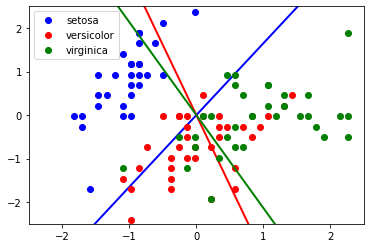

In [299]:
# Это график с новым параметром в разделяющей гиперплоскости = 1
cols = ['blue','red', 'green' ]
class_names = iris.target_names
plt.xlim( (-2.5, 2.5) )
plt.ylim( (-2.5, 2.5) )

# построим выборки
for  i in np.unique(Y):
    plt.plot(X[Y[:,0]==i,0] , X[Y[:,0]==i,1], 'o',label = f'{class_names[i]}', color = cols[i]  )
    
    k = -coefs[i][1][0]/coefs[i][0][0]
    print(f'y = {k:.2f} * x')
    x_axis = np.linspace(-50,50)
    y_axis = k * x_axis
    plt.plot(x_axis, y_axis, linewidth=2, color = cols[i])
    
plt.legend(loc='best')    

 
0.978 x
 
10.77 x
 
-2.908 x


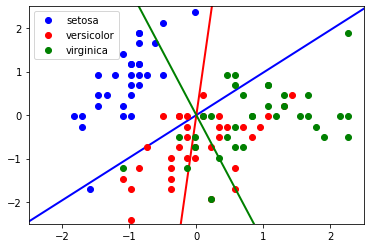

In [313]:
# Это график такой же что и выше, только с новым параметром в разделяющей гиперплоскости = 10

cols = ['blue','red', 'green' ]
class_names = iris.target_names
plt.xlim( (-2.5, 2.5) )
plt.ylim( (-2.5, 2.5) )

# построим выборки, на 2D плоскости из двух параметров X[:,0] и X[:,1]
for  i in np.unique(Y):
    plt.plot(X[Y[:,0]==i,0] , X[Y[:,0]==i,1], 'o',label = f'{class_names[i]}', color = cols[i]  )
    # Строим разделяющую кривую.. 
    x2 , y2 = -coefs[i][0][0]/coefs[i][1][0],1
    poly = np.poly1d( np.polyfit([0,x2],[0,y2],1) )
    print(poly)
    x_axis = np.linspace(-50,50)
    y_axis = poly(x_axis)
    plt.plot(x_axis, y_axis, linewidth=2, color = cols[i])
    
plt.legend(loc='best')    

Есть одна мысль, что путем перебора мы найдем такую разделяющую линию, что количество ошибок будет мминимальным..

Протестируем на X_test и найдем тот класс у которого вероятность выше.

In [315]:
X = scaler.fit_transform(X_test)
X = np.array(np.hstack( [X, np.ones( [len(X), 1], dtype=np.float64  )*10   ]  )  , dtype=np.float64) # добавим еще один признак - получится на один признак больше - разделяющая гипер-плоскость будет иметь на одну плоскость больше
Y = np.array(y_test, dtype=np.int64)
Y = Y.reshape(-1,1)

In [331]:
accuracy_score?

In [333]:
a = []        # служебный. создаем пустой массив в который сбросим все результаты логита по трем классам. 
y_pred = []   # результирующий массив. 

for i in range(len(X)):     # бегаем по выборке X_test
    for j in range(3):  # с каждым значением X_test_i делаем логит и проверяем максимум логита
        a.append( logit(X[i], coefs[j]) )
    y_pred.append(np.argmax(a,axis=0)[0] )
    a = []
    #break

In [334]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.98

Неплохо для многоклассового логита.